In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
from waymo_open_dataset import dataset_pb2 as open_dataset
import matplotlib.pyplot as plt
import dask.dataframe as dd
import tensorflow as tf
from waymo_open_dataset import v2
import time
from typing import Any, Dict, Iterator, List, Optional, Sequence, Tuple
from waymo_open_dataset.utils import camera_segmentation_utils
import cv2
tf.compat.v1.enable_eager_execution()

from DataLoader.pvps_dataset import PanopticSegmentationDataset

2023-04-15 13:55:59.000682: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 13:55:59.367703: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-15 13:56:00.673583: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ros/f

In [2]:
train_transform = transforms.Compose([
    transforms.ToTensor()
])
batch_size = 32
datasetNum = 10 # for testing. Only fetch 10 timestamps
desired_context_name = None # optionally, you can only load a specific context name
desired_timestamp = None # you can even specify a particular timestamp. Make sure it's within the context name.
frames_path = "/media/kaiwenjon/Kevin-linux-dats/waymo/dataset_v2/training/camera_image"
labels_path = "/media/kaiwenjon/Kevin-linux-dats/waymo/dataset_v2/training/camera_segmentation"
frames_id_list_path = "./2d_pvps_training_frames.txt"
dataset = PanopticSegmentationDataset(frames_path, labels_path, frames_id_list_path, datasetNum, desired_context_name, desired_timestamp, transform=train_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

Data prepared to be imported:
context_name:  10017090168044687777_6380_000_6400_000 Timestamp:  1550083469645130
context_name:  10017090168044687777_6380_000_6400_000 Timestamp:  1550083470045260
context_name:  10017090168044687777_6380_000_6400_000 Timestamp:  1550083470245288
context_name:  10017090168044687777_6380_000_6400_000 Timestamp:  1550083470445324
context_name:  10017090168044687777_6380_000_6400_000 Timestamp:  1550083470845389
context_name:  10017090168044687777_6380_000_6400_000 Timestamp:  1550083474648906
context_name:  10017090168044687777_6380_000_6400_000 Timestamp:  1550083475049006
context_name:  10017090168044687777_6380_000_6400_000 Timestamp:  1550083475249048
context_name:  10017090168044687777_6380_000_6400_000 Timestamp:  1550083475449087
context_name:  10017090168044687777_6380_000_6400_000 Timestamp:  1550083475849035


2023-04-15 13:56:02.809127: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-15 13:56:03.187207: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-15 13:56:03.187622: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-15 13:56:03.188662: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

6.05 s, imported  10017090168044687777_6380_000_6400_000 1550083469645130
0.92 s, imported  10017090168044687777_6380_000_6400_000 1550083470045260
0.95 s, imported  10017090168044687777_6380_000_6400_000 1550083470245288


KeyboardInterrupt: 

Visualize frames and labels for the first timestamp in the first batch


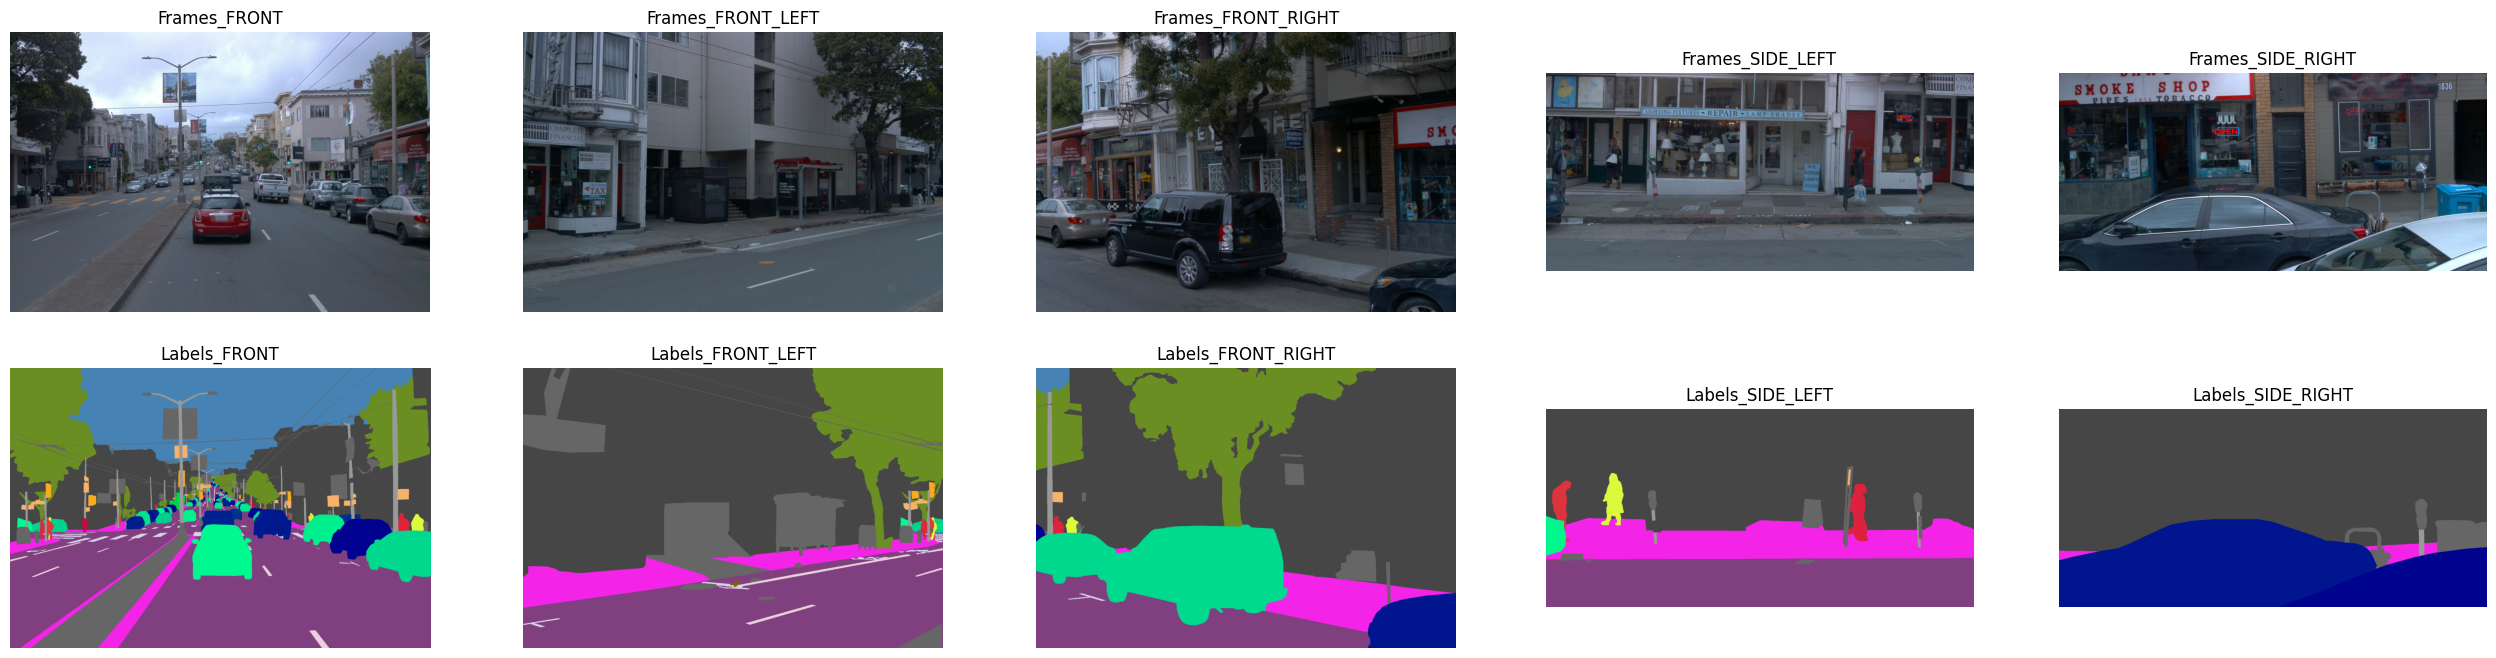

In [27]:
for batch_idx, (frames, labels) in enumerate(dataloader):
    # data format
    # frames: a list[FRONT_list, FRONT_LEFT_list, FRONT_RIGHT_list, SIDE_LEFT_list, SIDERIGHT_list]
    # frames[0]: FRONT_list: a list[FRONT_TENSOR, CameraNameTuple]
    # frames[0][0]: FRONT_TENSOR: torch.Size([batch_size, 3, 1280, 1920])
    # frames[0][1]: CameraNameTuple: ('FRONT', 'FRONT', 'FRONT', ....(batch_size)), in theory they should all be the same

    # labels: a list[FRONT_list, FRONT_LEFT_list, FRONT_RIGHT_list, SIDE_LEFT_list, SIDERIGHT_list]
    # labels[0]: FRONT_list: a list[FRONT_semantic_label_tensor, FRONT_instance_label_tensor, panoptic_label_tensor, CameraNameTuple]
    # labels[0][0]: FRONT_semantic_label_tensor: torch.Size([batch_size, 1, 1280, 1920])
    # labels[0][1]: FRONT_instance_label_tensor: torch.Size([batch_size, 1, 1280, 1920])
    # labels[0][2]: FRONT_panoptic_rgb_label_tensor: torch.Size([batch_size, 3, 1280, 1920])
    # labels[0][3]: CameraNameTuple: ('FRONT', 'FRONT', 'FRONT', ....(batch_size)), in theory they should all be the same
    for i in camera_name_list:
        cameraTupleFrame = frames[i-1][1]
        cameraTupleLabel = labels[i-1][3]
        assert all(element == cameraTupleFrame[0] for element in cameraTupleFrame)
        assert all(element == cameraTupleLabel[0] for element in cameraTupleLabel)
        assert cameraTupleFrame[0] == camera_name_list[i]
        assert cameraTupleLabel[0] == camera_name_list[i]
    
    # torch.Size([batch_size, 3, 1280, 1920])
    imgs_FRONT = frames[0][0]
    imgs_FRONT_LEFT = frames[1][0]
    imgs_FRONT_RIGHT = frames[2][0]
    imgs_SIDE_LEFT = frames[3][0]
    imgs_SIDE_RIGHT = frames[4][0]
    
    # torch.Size([batch_size, 1, 1280, 1920])
    semantic_labels_FRONT = labels[0][0]
    semantic_labels_FRONT_LEFT = labels[1][0]
    semantic_labels_FRONT_RIGHT = labels[2][0]
    semantic_labels_SIDE_LEFT = labels[3][0]
    semantic_labels_SIDE_RIGHT = labels[4][0]
    
    # torch.Size([batch_size, 1, 1280, 1920])
    instance_labels_FRONT = labels[0][1]
    instance_labels_FRONT_LEFT = labels[1][1]
    instance_labels_FRONT_RIGHT = labels[2][1]
    instance_labels_SIDE_LEFT = labels[3][1]
    instance_labels_SIDE_RIGHT = labels[4][1]
    
    # torch.Size([batch_size, 3, 1280, 1920])
    panoptic_rgb_labels_FRONT = labels[0][2]
    panoptic_rgb_labels_FRONT_LEFT = labels[1][2]
    panoptic_rgb_labels_FRONT_RIGHT = labels[2][2]
    panoptic_rgb_labels_SIDE_LEFT = labels[3][2]
    panoptic_rgb_labels_SIDE_RIGHT = labels[4][2]
    
    if(batch_idx == 0):
        timestamp_to_plot = 0 # any num within batch_size
        print("Visualize frames and labels for the first timestamp in the first batch")
        fig, axs = plt.subplots(2, 5, figsize=(32, 8), subplot_kw={'xticks': [], 'yticks': []})
        for i in range(5):
            img = frames[i][0][timestamp_to_plot].squeeze().permute(1, 2, 0).numpy()
            axs[0, i].imshow(img)
            axs[0, i].axis('off')
            axs[0, i].set_title(f'Frames_{frames[i][1][0]}')
            img = np.float32(img)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(f'Frames_{frames[i][1][0]}.png', img_rgb)

        # Plot the remaining 5 images in the second row
        for i in range(5):
            img = labels[i][2][timestamp_to_plot].squeeze().permute(1, 2, 0).numpy()
            axs[1, i].imshow(img)
            axs[1, i].axis('off')
            axs[1, i].set_title(f'Labels_{labels[i][3][0]}')
            img = np.float32(img)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(f'Labels_{labels[i][3][0]}.png', img_rgb)

        # Show the plot
        plt.show()
    
    

In [8]:
test_transform = transforms.Compose([
    transforms.ToTensor()
])
datasetNum = 10 # for testing. Only fetch 10 timestamps
desired_context_name = None # optionally, you can only load a specific context name
desired_timestamp = None # you can even specify a particular timestamp. Make sure it's within the context name.
frames_path = "/media/kaiwenjon/Kevin-linux-dats/waymo/dataset_v2/testing_location/camera_image"
labels_path = "/media/kaiwenjon/Kevin-linux-dats/waymo/dataset_v2/testing_location/camera_segmentation"
frames_id_list_path = "./2d_pvps_test_frames.txt"
dataset = PanopticSegmentationDataset(frames_path, labels_path, frames_id_list_path, datasetNum, desired_context_name, desired_timestamp, transform=train_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

Data prepared to be imported:
context_name:  10149575340910243572_2720_000_2740_000 Timestamp:  1558035217562493
context_name:  10149575340910243572_2720_000_2740_000 Timestamp:  1558035217762472
context_name:  10149575340910243572_2720_000_2740_000 Timestamp:  1558035217962441
context_name:  10149575340910243572_2720_000_2740_000 Timestamp:  1558035218162443
context_name:  10149575340910243572_2720_000_2740_000 Timestamp:  1558035218362457
context_name:  10149575340910243572_2720_000_2740_000 Timestamp:  1558035218562478
context_name:  10149575340910243572_2720_000_2740_000 Timestamp:  1558035218762563
context_name:  10149575340910243572_2720_000_2740_000 Timestamp:  1558035218962606
context_name:  10149575340910243572_2720_000_2740_000 Timestamp:  1558035219162662
context_name:  10149575340910243572_2720_000_2740_000 Timestamp:  1558035219362780


/home/kaiwenjon/anaconda3/lib/python3.9/site-packages/dask/dataframe/groupby.py:1118: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  dict(column=input_column, func=lambda s: s.apply(list)),
/home/kaiwenjon/anaconda3/lib/python3.9/site-packages/dask/dataframe/groupby.py:1127: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby

IndexError: list index out of range

In [ ]:
validation_transform = transforms.Compose([
    transforms.ToTensor()
])
datasetNum = 10 # for testing. Only fetch 10 timestamps
desired_context_name = None # optionally, you can only load a specific context name
desired_timestamp = None # you can even specify a particular timestamp. Make sure it's within the context name.
frames_path = "/media/kaiwenjon/Kevin-linux-dats/waymo/dataset_v2/validation/camera_image"
labels_path = "/media/kaiwenjon/Kevin-linux-dats/waymo/dataset_v2/validation/camera_segmentation"
frames_id_list_path = "./2d_pvps_validation_frames.txt"
dataset = PanopticSegmentationDataset(frames_path, labels_path, frames_id_list_path, datasetNum, desired_context_name, desired_timestamp, transform=train_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

0 s, Adding  1024360143612057520_3580_000_3600_000


Loaded image (430782 bytes) for camera_image.key.camera_name=1 1553628864248893 camera_image.key.camera_name=1


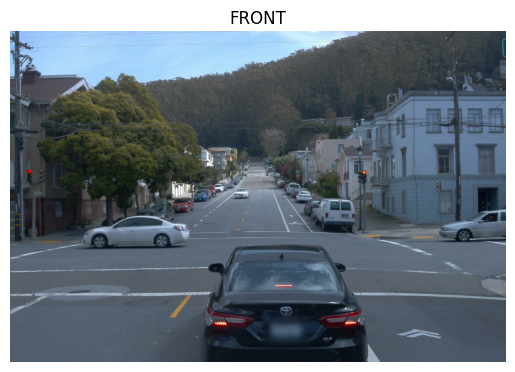

0
Loaded image (456226 bytes) for camera_image.key.camera_name=2 1553628864248893 camera_image.key.camera_name=2
Loaded image (310542 bytes) for camera_image.key.camera_name=4 1553628864248893 camera_image.key.camera_name=4
Loaded image (341771 bytes) for camera_image.key.camera_name=3 1553628864248893 camera_image.key.camera_name=3
Loaded image (194267 bytes) for camera_image.key.camera_name=5 1553628864248893 camera_image.key.camera_name=5
Loaded image (431692 bytes) for camera_image.key.camera_name=1 1553628864348883 camera_image.key.camera_name=1
Loaded image (456370 bytes) for camera_image.key.camera_name=2 1553628864348883 camera_image.key.camera_name=2
Loaded image (310632 bytes) for camera_image.key.camera_name=4 1553628864348883 camera_image.key.camera_name=4
Loaded image (341943 bytes) for camera_image.key.camera_name=3 1553628864348883 camera_image.key.camera_name=3
Loaded image (194525 bytes) for camera_image.key.camera_name=5 1553628864348883 camera_image.key.camera_name=5

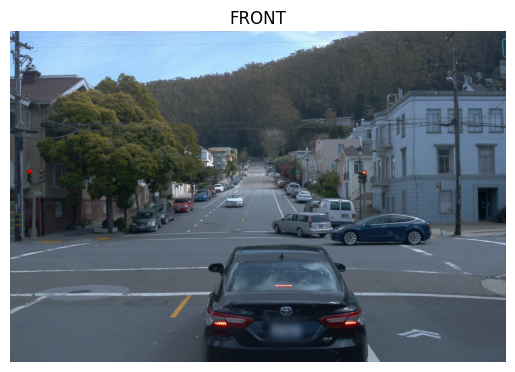

100
Loaded image (455528 bytes) for camera_image.key.camera_name=2 1553628866248862 camera_image.key.camera_name=2
Loaded image (310601 bytes) for camera_image.key.camera_name=4 1553628866248862 camera_image.key.camera_name=4
Loaded image (341349 bytes) for camera_image.key.camera_name=3 1553628866248862 camera_image.key.camera_name=3
Loaded image (194588 bytes) for camera_image.key.camera_name=5 1553628866248862 camera_image.key.camera_name=5
Loaded image (428832 bytes) for camera_image.key.camera_name=1 1553628866348889 camera_image.key.camera_name=1
Loaded image (455872 bytes) for camera_image.key.camera_name=2 1553628866348889 camera_image.key.camera_name=2
Loaded image (310946 bytes) for camera_image.key.camera_name=4 1553628866348889 camera_image.key.camera_name=4
Loaded image (341124 bytes) for camera_image.key.camera_name=3 1553628866348889 camera_image.key.camera_name=3
Loaded image (194471 bytes) for camera_image.key.camera_name=5 1553628866348889 camera_image.key.camera_name

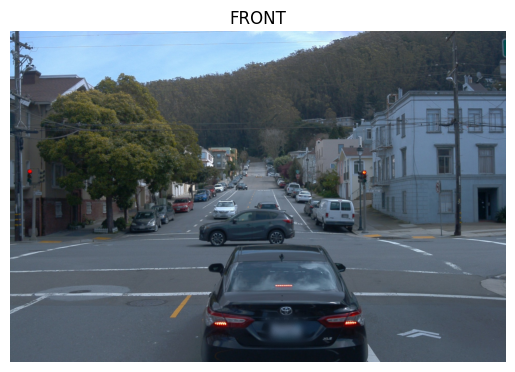

200
Loaded image (457085 bytes) for camera_image.key.camera_name=2 1553628868248879 camera_image.key.camera_name=2
Loaded image (311488 bytes) for camera_image.key.camera_name=4 1553628868248879 camera_image.key.camera_name=4
Loaded image (341577 bytes) for camera_image.key.camera_name=3 1553628868248879 camera_image.key.camera_name=3
Loaded image (194270 bytes) for camera_image.key.camera_name=5 1553628868248879 camera_image.key.camera_name=5
Loaded image (427659 bytes) for camera_image.key.camera_name=1 1553628868348901 camera_image.key.camera_name=1
Loaded image (456835 bytes) for camera_image.key.camera_name=2 1553628868348901 camera_image.key.camera_name=2
Loaded image (311221 bytes) for camera_image.key.camera_name=4 1553628868348901 camera_image.key.camera_name=4
Loaded image (341079 bytes) for camera_image.key.camera_name=3 1553628868348901 camera_image.key.camera_name=3
Loaded image (194208 bytes) for camera_image.key.camera_name=5 1553628868348901 camera_image.key.camera_name

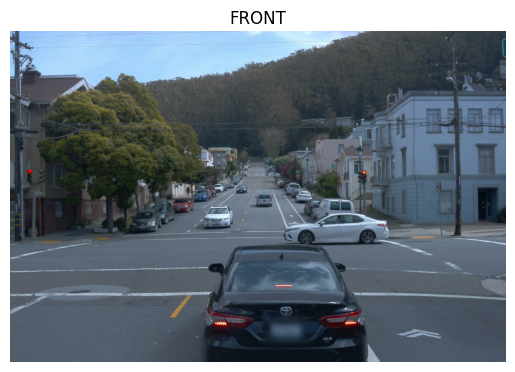

300
Loaded image (456754 bytes) for camera_image.key.camera_name=2 1553628870248899 camera_image.key.camera_name=2
Loaded image (312148 bytes) for camera_image.key.camera_name=4 1553628870248899 camera_image.key.camera_name=4
Loaded image (338774 bytes) for camera_image.key.camera_name=3 1553628870248899 camera_image.key.camera_name=3
Loaded image (194044 bytes) for camera_image.key.camera_name=5 1553628870248899 camera_image.key.camera_name=5
Loaded image (429622 bytes) for camera_image.key.camera_name=1 1553628870348924 camera_image.key.camera_name=1
Loaded image (456603 bytes) for camera_image.key.camera_name=2 1553628870348924 camera_image.key.camera_name=2
Loaded image (312170 bytes) for camera_image.key.camera_name=4 1553628870348924 camera_image.key.camera_name=4
Loaded image (338495 bytes) for camera_image.key.camera_name=3 1553628870348924 camera_image.key.camera_name=3
Loaded image (194470 bytes) for camera_image.key.camera_name=5 1553628870348924 camera_image.key.camera_name

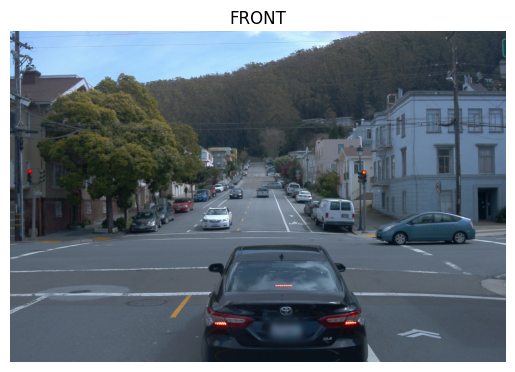

400
Loaded image (457593 bytes) for camera_image.key.camera_name=2 1553628872248975 camera_image.key.camera_name=2
Loaded image (313422 bytes) for camera_image.key.camera_name=4 1553628872248975 camera_image.key.camera_name=4
Loaded image (340909 bytes) for camera_image.key.camera_name=3 1553628872248975 camera_image.key.camera_name=3
Loaded image (194078 bytes) for camera_image.key.camera_name=5 1553628872248975 camera_image.key.camera_name=5
Loaded image (432200 bytes) for camera_image.key.camera_name=1 1553628872348961 camera_image.key.camera_name=1
Loaded image (457331 bytes) for camera_image.key.camera_name=2 1553628872348961 camera_image.key.camera_name=2
Loaded image (313580 bytes) for camera_image.key.camera_name=4 1553628872348961 camera_image.key.camera_name=4
Loaded image (340241 bytes) for camera_image.key.camera_name=3 1553628872348961 camera_image.key.camera_name=3
Loaded image (194418 bytes) for camera_image.key.camera_name=5 1553628872348961 camera_image.key.camera_name

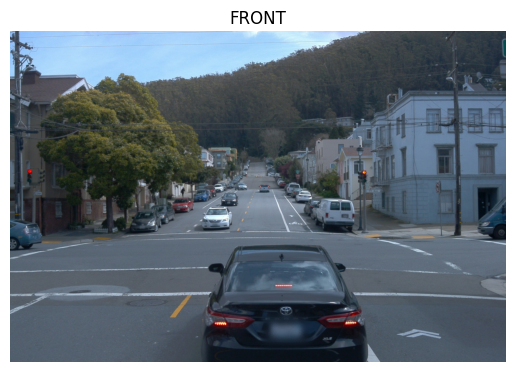

500
Loaded image (457782 bytes) for camera_image.key.camera_name=2 1553628874248951 camera_image.key.camera_name=2
Loaded image (314311 bytes) for camera_image.key.camera_name=4 1553628874248951 camera_image.key.camera_name=4
Loaded image (339241 bytes) for camera_image.key.camera_name=3 1553628874248951 camera_image.key.camera_name=3
Loaded image (194757 bytes) for camera_image.key.camera_name=5 1553628874248951 camera_image.key.camera_name=5
Loaded image (433957 bytes) for camera_image.key.camera_name=1 1553628874348939 camera_image.key.camera_name=1
Loaded image (457310 bytes) for camera_image.key.camera_name=2 1553628874348939 camera_image.key.camera_name=2
Loaded image (314446 bytes) for camera_image.key.camera_name=4 1553628874348939 camera_image.key.camera_name=4
Loaded image (339681 bytes) for camera_image.key.camera_name=3 1553628874348939 camera_image.key.camera_name=3
Loaded image (194762 bytes) for camera_image.key.camera_name=5 1553628874348939 camera_image.key.camera_name

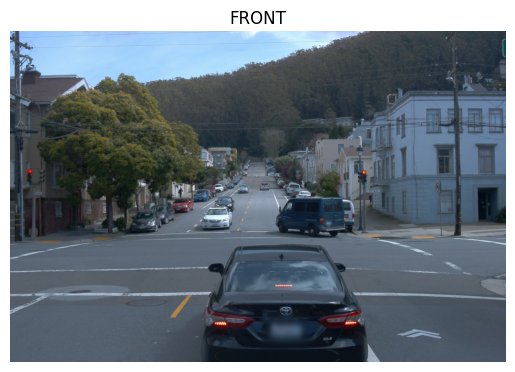

600
Loaded image (456113 bytes) for camera_image.key.camera_name=2 1553628876248899 camera_image.key.camera_name=2
Loaded image (314543 bytes) for camera_image.key.camera_name=4 1553628876248899 camera_image.key.camera_name=4
Loaded image (340981 bytes) for camera_image.key.camera_name=3 1553628876248899 camera_image.key.camera_name=3
Loaded image (194343 bytes) for camera_image.key.camera_name=5 1553628876248899 camera_image.key.camera_name=5
Loaded image (430953 bytes) for camera_image.key.camera_name=1 1553628876348889 camera_image.key.camera_name=1
Loaded image (456406 bytes) for camera_image.key.camera_name=2 1553628876348889 camera_image.key.camera_name=2
Loaded image (315015 bytes) for camera_image.key.camera_name=4 1553628876348889 camera_image.key.camera_name=4
Loaded image (341131 bytes) for camera_image.key.camera_name=3 1553628876348889 camera_image.key.camera_name=3
Loaded image (194525 bytes) for camera_image.key.camera_name=5 1553628876348889 camera_image.key.camera_name

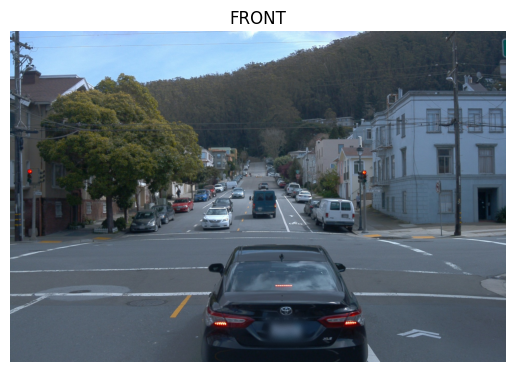

700
Loaded image (456659 bytes) for camera_image.key.camera_name=2 1553628878248901 camera_image.key.camera_name=2
Loaded image (314918 bytes) for camera_image.key.camera_name=4 1553628878248901 camera_image.key.camera_name=4
Loaded image (340357 bytes) for camera_image.key.camera_name=3 1553628878248901 camera_image.key.camera_name=3
Loaded image (194438 bytes) for camera_image.key.camera_name=5 1553628878248901 camera_image.key.camera_name=5
Loaded image (431705 bytes) for camera_image.key.camera_name=1 1553628878348891 camera_image.key.camera_name=1
Loaded image (456528 bytes) for camera_image.key.camera_name=2 1553628878348891 camera_image.key.camera_name=2
Loaded image (314758 bytes) for camera_image.key.camera_name=4 1553628878348891 camera_image.key.camera_name=4
Loaded image (340352 bytes) for camera_image.key.camera_name=3 1553628878348891 camera_image.key.camera_name=3
Loaded image (194671 bytes) for camera_image.key.camera_name=5 1553628878348891 camera_image.key.camera_name

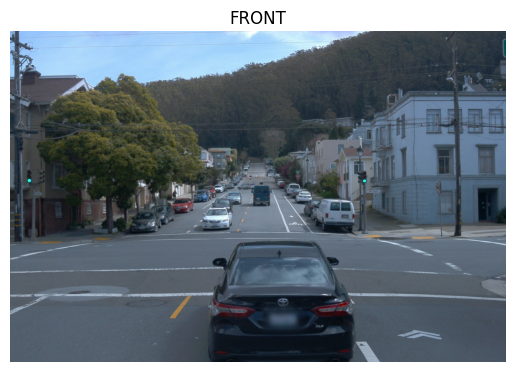

800
Loaded image (453292 bytes) for camera_image.key.camera_name=2 1553628880248841 camera_image.key.camera_name=2
Loaded image (314846 bytes) for camera_image.key.camera_name=4 1553628880248841 camera_image.key.camera_name=4
Loaded image (337384 bytes) for camera_image.key.camera_name=3 1553628880248841 camera_image.key.camera_name=3
Loaded image (193680 bytes) for camera_image.key.camera_name=5 1553628880248841 camera_image.key.camera_name=5
Loaded image (427639 bytes) for camera_image.key.camera_name=1 1553628880348826 camera_image.key.camera_name=1
Loaded image (453105 bytes) for camera_image.key.camera_name=2 1553628880348826 camera_image.key.camera_name=2
Loaded image (315233 bytes) for camera_image.key.camera_name=4 1553628880348826 camera_image.key.camera_name=4
Loaded image (337733 bytes) for camera_image.key.camera_name=3 1553628880348826 camera_image.key.camera_name=3
Loaded image (193953 bytes) for camera_image.key.camera_name=5 1553628880348826 camera_image.key.camera_name

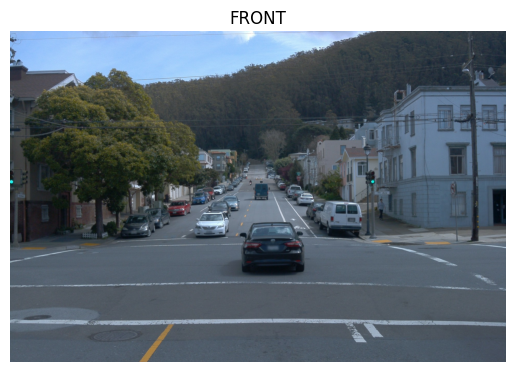

900
Loaded image (439043 bytes) for camera_image.key.camera_name=2 1553628882249087 camera_image.key.camera_name=2
Loaded image (320215 bytes) for camera_image.key.camera_name=4 1553628882249087 camera_image.key.camera_name=4
Loaded image (344773 bytes) for camera_image.key.camera_name=3 1553628882249087 camera_image.key.camera_name=3
Loaded image (192042 bytes) for camera_image.key.camera_name=5 1553628882249087 camera_image.key.camera_name=5
Loaded image (423242 bytes) for camera_image.key.camera_name=1 1553628882349071 camera_image.key.camera_name=1
Loaded image (437747 bytes) for camera_image.key.camera_name=2 1553628882349071 camera_image.key.camera_name=2
Loaded image (318888 bytes) for camera_image.key.camera_name=4 1553628882349071 camera_image.key.camera_name=4
Loaded image (348960 bytes) for camera_image.key.camera_name=3 1553628882349071 camera_image.key.camera_name=3
Loaded image (192191 bytes) for camera_image.key.camera_name=5 1553628882349071 camera_image.key.camera_name

In [47]:
from waymo_open_dataset import dataset_pb2 as open_dataset
import matplotlib.pyplot as plt
import dask.dataframe as dd
import tensorflow as tf
from waymo_open_dataset import v2


camera_left_to_right_order = [open_dataset.CameraName.SIDE_LEFT, #4
                            open_dataset.CameraName.FRONT_LEFT, #2
                            open_dataset.CameraName.FRONT, #1
                            open_dataset.CameraName.FRONT_RIGHT, #3
                            open_dataset.CameraName.SIDE_RIGHT] #5

camera_name_list = {
   1 : "FRONT",
   2 : "FRONT_LEFT",
   3 : "FRONT_RIGHT",
   4 : "SIDE_LEFT",
   5 : "SIDE_RIGHT"
}
camera_name_num = 1

# Path to the directory with all components
dataset_dir = '/media/kaiwenjon/Kevin-linux-dats/waymo/dataset_v2/validation'

context_name = '17065833287841703_2980_000_3000_000'

def read(tag: str) -> dd.DataFrame:
  """Creates a Dask DataFrame for the component specified by its tag."""
  paths = tf.io.gfile.glob(f'{dataset_dir}/{tag}/{context_name}.parquet')
  return dd.read_parquet(paths)


camera_image_df = read('camera_image')
# Filter the images from camera=1
# NOTE: We could also use push down filters while reading the parquet files as well
# Details https://docs.dask.org/en/stable/generated/dask.dataframe.read_parquet.html#dask.dataframe.read_parquet
# camera_image_df = camera_image_df[camera_image_df['key.camera_name'] == camera_name_num]

# camera_box_df = read('camera_box')
# # Inner join the camera_image table with the camera_box table.
# df = camera_image_df.merge(
#     camera_box_df,
#     on=[
#         'key.segment_context_name',
#         'key.frame_timestamp_micros',
#         'key.camera_name',
#     ],
#     how='inner',
# )
for i, (key_values, row) in enumerate(camera_image_df.iterrows()):
    # Create corresponding components from the raw
#     _, row = next(iter(camera_image_df.iterrows()))

    camera_image = v2.CameraImageComponent.from_dict(row)

    print(
            f'Loaded image ({len(camera_image.image)} bytes) for'
            f' {camera_image.key.camera_name=} {camera_image.key.frame_timestamp_micros} {camera_image.key.camera_name=}'
        )
    if(i % 100 == 0):
        plt.imshow(tf.image.decode_jpeg(camera_image.image))
        plt.title(camera_name_list[camera_image.key.camera_name])
        plt.grid(False)
        plt.axis('off')
        plt.show()
        print(i)